In [1]:
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
import pytz

In [2]:
import risk_model
import factorize
import account

In [3]:
availabe_accounts = pd.read_csv('account_ids.txt',header=None)
print (availabe_accounts.values)

[['DU1440139']
 ['U2909804']]


In [4]:
account_number = availabe_accounts.values[0][0]

In [5]:
rth = False

In [6]:
if account_number == availabe_accounts.values[1][0]:

    optimal_weights_regularized = pd.read_csv('data/optimal_weights_regularized_sa.csv',index_col = 'asset')
    close = pd.read_csv('data/close_sa.csv', index_col = 'date')
    
elif account_number == availabe_accounts.values[0][0]:
    
    optimal_weights_regularized = pd.read_csv('output/optimal_weights_regularized.csv',index_col = 'asset')
    close = pd.read_csv('data/close.csv', index_col = 'date')

# 1 - Portfolio Management

In [7]:
portfolio = account.read_positions(subscribe = True, acctCode = account_number)

PositionEnd
Reading Portfolio


In [8]:
acc = account.read_account(reqId = 0, subscribe = True, acctCode = account_number)

AccountDownloadEnd. Account: DU1440139
Reading Account


In [9]:
all_weights, long, short, grv = risk_model.portfolio_calculation(portfolio)

In [10]:
long_value = long['marketValue'].sum()
short_value = short['marketValue'].sum()
#print ('Buying Power: {} $'.format(np.round(float(acc.loc['BuyingPower',:].values[0]), 4)))
print ('Gross Market Value: {} $'.format(np.round(grv, 4)))
print (' Long Value: {} $'.format(np.round(long_value,4)))
print (' Short Value: {} $'.format(np.round(short_value,4)))
print (' Net Liquidation: {} $'.format(np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)))
print (' Unrealize PNL: {} $'.format(np.round(portfolio['unrealizedPNL'].sum()),4))
print (' Loan Value: {} $'.format(np.round(float(acc.loc['GrossPositionValue'][0]) - float(acc.loc['EquityWithLoanValue'][0]), 4)))
print ('#####################################')
print ('Leverage Value: {}'.format(np.round(grv/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Long Leverage Value: {}'.format(np.round(long_value/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Short Leverage Value: {}'.format(np.round(np.abs(short_value)/float(acc.loc['EquityWithLoanValue'][0]), 4)))       

Gross Market Value: 235728.08 $
 Long Value: 142722.86 $
 Short Value: -93005.22 $
 Net Liquidation: 155545.0 $
 Unrealize PNL: 2825.0 $
 Loan Value: 80183.0 $
#####################################
Leverage Value: 1.5155
 Long Leverage Value: 0.9176
 Short Leverage Value: 0.5979


In [11]:
universe = portfolio.index
long_universe = long.index 
short_universe = short.index 

In [12]:
net_liq = np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)

## Projected portfolio balance

In [13]:
target_leverage = 1.5
grv_target = net_liq * target_leverage
excess_grv = grv_target - grv
print (excess_grv,'$')
marketVal_target = all_weights * grv_target

-2410.579999999987 $


In [14]:
balancing_order = marketVal_target['weights'] - portfolio['marketValue']
df_port = portfolio['marketPrice']
action_balance = pd.DataFrame(index = df_port.index, columns = ['shares'])
action_balance['shares'] = np.round(balancing_order / df_port,2)
to_drop = action_balance[action_balance['shares']==0.0].index
action_balance.drop(to_drop,axis=0,inplace=True)

In [15]:
grv_target

233317.5

In [16]:
val = account.read_nextvalidid(reqId=-1)

NextValidId: 1297


## Filtering stocks with significant market value

In [17]:
df_c = pd.DataFrame(data=close[optimal_weights_regularized.index].iloc[-1].values,
                   index = close[optimal_weights_regularized.index].iloc[-1].index,
                   columns = ['close'])
df_c.index.name = 'asset'

In [18]:
#optimal_weights_regularized = optimal_weights_regularized.round(2)

In [19]:
# dropping securities with less than 1% allocation 
#optimal_selected = optimal_weights_regularized[optimal_weights_regularized['optimal_weights'] != 0.00]

In [20]:
# print ('##########################################################')
# print ('dropping {} securities which have less than 1% allocation'.format(len(optimal_weights_regularized[optimal_weights_regularized['optimal_weights'] == 0.00].index)))
# print ('##########################################################')

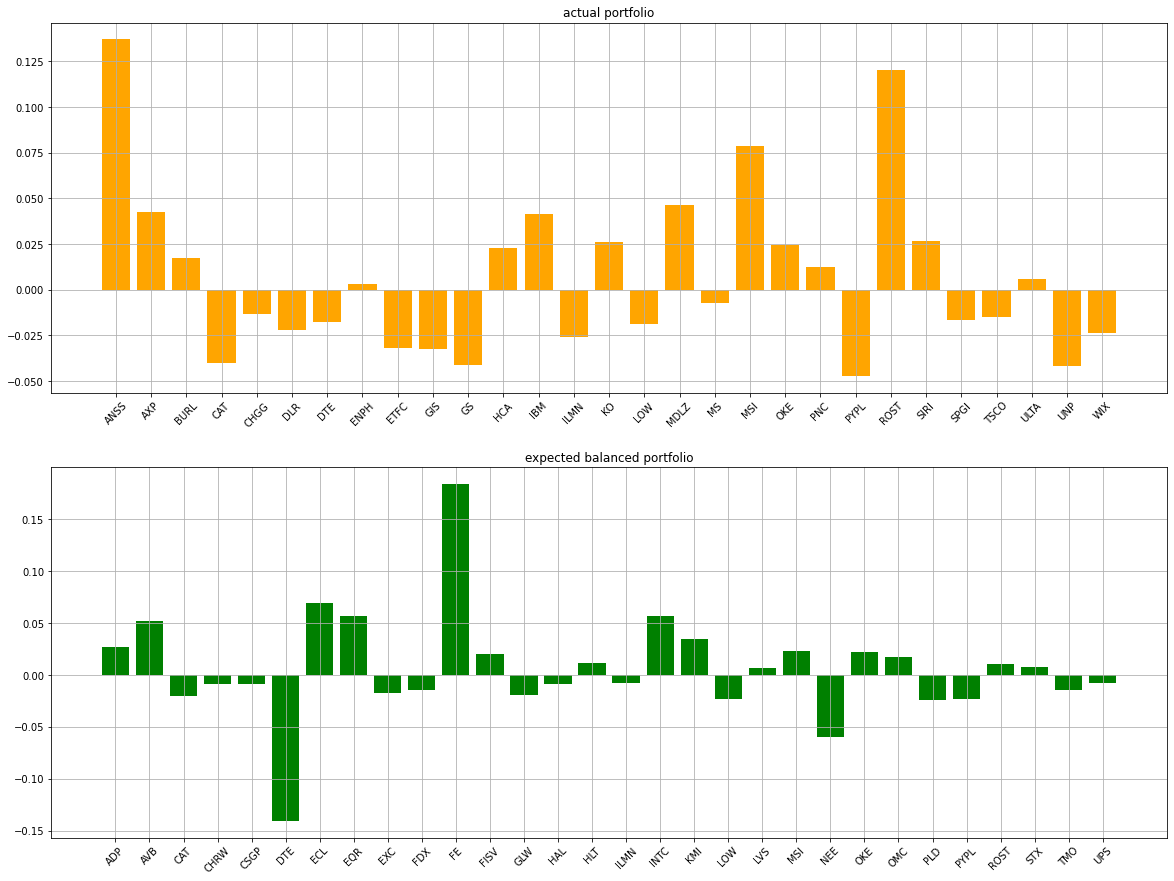

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))

x1 = all_weights.index
y1 = all_weights.values.flatten()
axs[0].grid(True)
axs[0].bar(x1, y1, width = 0.8, linewidth = 1, color='orange')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
axs[0].set_title('actual portfolio')

x2 = optimal_weights_regularized.index
y2 = optimal_weights_regularized.values.flatten()
axs[1].grid(True,)
axs[1].bar(x2, y2, width = 0.8, linewidth = 1, color='green')
for tick in axs[1].get_xticklabels():
    tick.set_rotation(45)
axs[1].set_title('expected balanced portfolio')
plt.show()

## Processing data for execution

In [22]:
stock_to_balance = portfolio.index & optimal_weights_regularized.index
stock_to_close = portfolio.index ^ stock_to_balance

In [23]:
df_c_target = df_c.reindex(optimal_weights_regularized.index)
shares_target_float = (optimal_weights_regularized * grv_target)['optimal_weights']/df_c_target['close']

In [24]:
portfolio_shares_float = portfolio['marketValue'] / portfolio['marketPrice']

In [25]:
# Rebalance to optimal weights
action_final = pd.DataFrame(index = shares_target_float.index, columns = ['shares'])

for i in shares_target_float.index:
    
    if (i in stock_to_balance) and (i not in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - portfolio_shares_float[i]
        
    elif (i in stock_to_balance) and (i in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - (portfolio_shares_float[i] + action_balance['shares'][i])

    elif (i in action_balance.index) and (i not in stock_to_balance):
        action_final.loc[i,'shares'] = shares_target_float[i] + action_balance['shares'][i]
    else:
        action_final.loc[i,'shares'] = shares_target_float[i]

In [26]:
# rename columns
portfolio_shares_float = pd.DataFrame(portfolio_shares_float,columns = ['portfolio_shares'],index=portfolio_shares_float.index)
shares_target_float = pd.DataFrame(shares_target_float,columns = ['target_shares_not_balanced'],index=shares_target_float.index)

action_balance.columns = ['balance_lev_shares']
action_final.columns = ['final_action_shares']

In [28]:
# replacing too small actions value with nan value
treshold_long = 1
treshold_short = -1

action_final[(action_final['final_action_shares']>0) & (action_final['final_action_shares']< treshold_long)] = np.nan
action_final[(action_final['final_action_shares']<0) & (action_final['final_action_shares']> treshold_short)] = np.nan
action_final[action_final['final_action_shares']==0.0] = np.nan
action_final.dropna(axis=0,inplace=True)
action_final['final_action_shares'] = pd.to_numeric(action_final['final_action_shares'], errors='coerce')

In [29]:
len(action_final)

30

In [30]:
action_conc = pd.concat([portfolio_shares_float,
                         action_balance,
                         shares_target_float,
                         action_final],axis=1)

In [31]:
isna_df = action_conc.isna()
for i in action_conc.index:
    if (isna_df.loc[i]['final_action_shares'] == True) & (isna_df.loc[i]['target_shares_not_balanced'] == False) :
        action_conc.drop(i, inplace = True)

In [32]:
action_conc.round(2)

,portfolio_shares,balance_lev_shares,target_shares_not_balanced,final_action_shares
ADP,NaN,NaN,47.47,47.47
ANSS,104.0,-1.06,NaN,NaN
AVB,NaN,NaN,79.29,79.29
AXP,108.0,-1.03,NaN,NaN
BURL,22.0,-0.29,NaN,NaN
CAT,-71.0,0.79,-35.97,34.24
CHGG,-38.0,0.44,NaN,NaN
CHRW,NaN,NaN,-22.79,-22.79
CSGP,NaN,NaN,-2.34,-2.34
DLR,-32.0,0.30,NaN,NaN


## Executing on TWS

In [47]:
op = account.cancel_openorders()

open order ended
open order ended


In [38]:
# closing positions not in shares target
if not stock_to_close.empty:
    next_order_id = account.closing_positions(stock_to_close = stock_to_close,
                                              portfolio = portfolio , 
                                              order_id = val)
else:
    print ('There is no stock to close...')
    next_order_id = val

app is running ...
closing 21 positions which are not present in action
closing position for ANSS is: 104 
closing position for AXP is: 108 
closing position for BURL is: 22 
closing position for CHGG is: 38 
closing position for DLR is: 32 
closing position for ENPH is: 13 
closing position for ETFC is: 148 
closing position for GIS is: 121 
closing position for GS is: 49 
closing position for HCA is: 42 
closing position for IBM is: 79 
closing position for KO is: 130 
closing position for MDLZ is: 198 
closing position for MS is: 35 
closing position for PNC is: 28 
closing position for SIRI is: 1078 
closing position for SPGI is: 11 
closing position for TSCO is: 25 
closing position for ULTA is: 7 
closing position for UNP is: 57 
closing position for WIX is: 19 


In [39]:
action_final = action_final.astype('int')
account.placing_final_orders(action_final=action_final, 
                             order_id = next_order_id)

buy order quantity placed for ADP is: 47 
buy order quantity placed for AVB is: 79 
buy order quantity placed for CAT is: 34 
sell order quantity placed for CHRW is: 22 
sell order quantity placed for CSGP is: 2 
sell order quantity placed for DTE is: 248 
buy order quantity placed for ECL is: 85 
buy order quantity placed for EQR is: 246 
sell order quantity placed for EXC is: 107 
sell order quantity placed for FDX is: 20 
buy order quantity placed for FE is: 1477 
buy order quantity placed for FISV is: 47 
sell order quantity placed for GLW is: 143 
sell order quantity placed for HAL is: 147 
buy order quantity placed for HLT is: 35 
buy order quantity placed for ILMN is: 11 
buy order quantity placed for INTC is: 276 
buy order quantity placed for KMI is: 577 
sell order quantity placed for LOW is: 6 
buy order quantity placed for LVS is: 37 
sell order quantity placed for MSI is: 92 
sell order quantity placed for NEE is: 49 
sell order quantity placed for OKE is: 19 
buy order qu

In [41]:
if rth:
    print ('we are in regular trading hours...')
    open_orders_all = account.get_openorders()
    if list(open_orders_all.values) == []:
        portfolio = account.read_positions(subscribe = True, acctCode = account_number)
        not_executed = portfolio.index ^ action_final.index
        print (not_executed)
        if list(not_executed)==[]:
            print ('all orders are executed')
    else:
        print ('some orders still not executed')
    
else:
    print ('we are not in regular trading hours...')
    open_orders_all = account.get_openorders()    
    not_executed = open_orders_all.index ^ action_conc.index
    
    if list(not_executed)==[]:
        print ('all orders are ready to be executed')
    
    else:
        print (list(not_executed))
        print ('some orders are not placed. please check manually or retry to run the functions')
    
    table = pd.concat([action_conc, open_orders_all[['open orders']]],axis=1)

we are not in regular trading hours...
open order ended
open order ended
all orders are ready to be executed


## Commission report of last realized trades

In [44]:
df = account.commission_report(acctCode = account_number, time= '')

In [45]:
df

,ticker,shares,action,price,marketValue,RealizedPNL,commission
time,,,,,,,


In [9]:
RealizedPNL = np.round(pd.to_numeric(df.loc[slice(execution_date)]['RealizedPNL'], errors='coerce').sum(),2)
#Total_Realized_Return = np.round((RealizedPNL/net_liq)*100,2)
print ('Report for {}:'.format(execution_date))
print (' Market Value: {} $'.format(np.round(df.loc[slice(execution_date)]['marketValue'].sum(),2)))
print (' Total Commission: {} $'.format(np.round(df.loc[slice(execution_date)]['commission'].sum(),2)))
print (' Total Realized PNL: {} $'.format(RealizedPNL))  
#print (' Total Realized Return: {} %'.format(Total_Realized_Return))  


NameError: name 'execution_date' is not defined

In [46]:
acc

,Values
Keys,
AccountCode,DU1440139
AccountOrGroup,DU1440139
AccountReady,true
AccountType,INDIVIDUAL
AccruedCash,0
AccruedCash-C,0
AccruedCash-S,0
AccruedDividend,0
AccruedDividend-C,0
